# Phishing and Spam Detection Using Various Machine Learning Algorithms

# 1 Introduction

Authors: Anisaftab Saiyed, Terrence Manly-Elliott, Noah Ndahirwa
Supervisor: Mohamad Hoda

In this research project, our objective is to develop machine learning models that can effectively detect spam and phishing emails. Spam and phishing emails pose significant threats to individuals and organizations, as they aim to deceive recipients and extract sensitive information or engage in malicious activities.

The detection of spam and phishing emails is a challenging task due to the constantly evolving techniques used by attackers. Machine learning algorithms provide a promising approach to tackle this problem by leveraging patterns and features within email content, headers, and metadata.

By training machine learning models on a diverse dataset of labeled emails, we aim to build robust classifiers that can accurately identify and classify spam and phishing emails. These models will be capable of distinguishing between legitimate emails and malicious ones, enabling users to take appropriate actions to protect themselves and their organizations.

Throughout this research project, we will explore various machine learning algorithms, including logistic regression, support vector machines, random forests, and neural networks. We will evaluate the performance of these models using metrics such as accuracy, precision, recall, and F1-score.

The outcomes of this research project have the potential to contribute to the development of effective email filtering systems and enhance email security for individuals and organizations. By improving the detection of spam and phishing emails, we can mitigate the risks associated with cyber threats and safeguard sensitive information.

# 2 Imports

In [526]:
import pandas as pd
import numpy as np
import re
import quopri
import spacy
import gc
import os
import warnings
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt
import prettytable as pt
import string
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from bs4 import BeautifulSoup
from email import message_from_string
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
import joblib

spam_vectorizer = TfidfVectorizer(
    max_features= 30000, 
    stop_words='english',
    lowercase=True
    )

phish_vectorizer = TfidfVectorizer(
    max_features= 30000, 
    stop_words='english',
    lowercase=True,
    )

In [527]:
warnings.filterwarnings('ignore')

# 3 Data Preparation

## Text Preprocessor

In [528]:
def preprocess(text):
    #Convert all text to lowercase
    text = text.lower()
    #Removing special whitespace characters
    text = re.sub(r"\s+", " ", text)

    #Convert html to plain text
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    #Trim whitespaces
    text = text.strip()

    #Replace phone numbers with placeholder
    phone_pattern = re.compile(
        r'(\+?\d{1,2}[-.\s]?)?'       
        r'(\(?\d{2,4}\)?[-.\s]?)'     
        r'\d{2,3}[-.\s]?'            
        r'\d{3,4}'                    
    )
    text = re.sub(phone_pattern, 'PHONE', text)

    url_pattern = r'\b(?:http|ftp|https)://[^\s()<>]+(?:\([\w\d]+\)|([^[:punct:]\s]|/))'
    text = re.sub(url_pattern, 'URL', text)

    return text

## 3.1 Spam Dataset

### 3.1.1 Data Extraction

In [529]:
spam_df = pd.read_csv("https://raw.githubusercontent.com/terrenceme/Honours_Project/main/Spam%20Email%20raw%20text%20for%20NLP.csv")
spam_df.rename(columns={'MESSAGE' : 'Email','CATEGORY': 'Spam'}, inplace=True)
# Display the entire content of MESSAGE column
pd.set_option('display.max_colwidth', 1000)

#Removing unrequired column
spam_df.drop(columns=['FILE_NAME'], inplace=True)

spam_df[20:30]

,Spam,Email
20,1,"<!-- saved from url=3D(0022)http://internet.e-mail -->\n\n<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Transitional//EN"">\n\n<HTML><HEAD>\n\n<META http-equiv=3DContent-Type content=3D""text/html; charset=3Diso-8859-1=\n\n"">\n\n</HEAD>\n\n<BODY>\n\n<TABLE height=3D400 cellSpacing=3D0 cellPadding=3D0 width=3D450 align=3Dce=\n\nnter border=3D0>\n\n <TBODY>\n\n <TR>\n\n <TD colSpan=3D2><A href=3D""http://marketing-fashion.com/user0201/index=\n\nasp?Afft=3DQM12""><IMG height=3D38 src=3D""http://61.129.68.17/mortgage/h1.=\n\ngif"" width=3D450 border=3D0></A></TD></TR>\n\n <TR>\n\n <TD width=3D138 height=3D178><A href=3D""http://marketing-fashion.com/u=\n\nser0201/index.asp?Afft=3DQM12""><IMG height=3D178 src=3D""http://61.129.68.1=\n\n7/mortgage/bullets.gif"" width=3D138 border=3D0></A></TD>\n\n <TD width=3D312 height=3D178><A href=3D""http://marketing-fashion.com/u=\n\nser0201/index.asp?Afft=3DQM12""><IMG height=3D178 src=3D""http://61.129.68.1=\n\n7/mortgage/family.jpg"" width=3D312 bord..."
21,1,"<html>\n\n\n\n<head>\n\n<meta http-equiv=""Content-Type"" content=""text/html; charset=windows-1252"">\n\n<meta name=""GENERATOR"" content=""Microsoft FrontPage 4.0"">\n\n<meta name=""ProgId"" content=""FrontPage.Editor.Document"">\n\n<title>Check the REPORTS you would like to receive</title>\n\n<meta http-equiv=""Content-Type"" content=""text/html; charset=iso-8859-1"">\n\n<style>\n\nA{color:navy; text-decoration:none; font-weight:bold; font-family:arial,helvetica,sans-serif}\n\nA:hover{color:red; text-decoration:none; font-weight:bold; font-family:arial,helvetica,sans-serif}\n\nA:active{color:ffcc00; text-decoration:none; font-weight:bold; font-family:arial,helvetica,sans-serif}\n\nA:visited{color:ffcc00; text-decoration:none; font-weight:bold; font-family:arial,helvetica,sans-serif}\n\nBODY{color:black; font-family:verdana}\n\nTD{font-family:arial,helvetica,sans-serif}\n\n</style>\n\n\n\n</head>\n\n<body bgcolor=""#C0C0C0"" text=""#003366"">\n\n<div align=""center""><center>\n\n\n\n<form action=""http..."
22,1,"\n\nWET, HORNY AND DIRTY GRANDMAS!\n\n\n\nRemember how you lusted after your friend's mum in high\n\nschool? She was 46 and you were 15? Remember the time\n\nwhen she bent over to do her gardening and you saw her\n\nsagging breasts through the v-neck opening of her summer\n\ndress? She was OLD and you LOVED her! All you wanted to\n\ndo was FUK that Dirty Old Mole BLUE! You can now! Follow\n\nthe link below to see just how OLD & DIRTY these moles are!\n\nhttp://62.16.101.30/jump2/index.html\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nRemove here:\n\nhttp://62.16.101.30/jump1/remove.html\n\n\n\n\n"
23,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Transitional//EN"">\n\n<HTML><HEAD><TITLE>Beautiful,Custom Websites for $349 Complete!</TITLE>\n\n<STYLE></STYLE>\n\n</head>\n\n<BODY text=#000000 vLink=#000080 aLink=#000080 link=#000080 bgColor=#000080 \n\ntopMargin=7>\n\n<CENTER>\n\n<TABLE borderColor=#000000 height=368 cellSpacing=0 cellPadding=3 width=575 \n\nbgColor=#79a5ff border=1>\n\n <TBODY>\n\n <TR>\n\n <TD width=565 bgColor=#000000 height=22>\n\n <P align=center><FONT face=Arial color=#ffffff><B>Beautiful, 100% Custom \n\n Websites, $349 Complete!</B></FONT></P></TD></TR>\n\n <TR>\n\n <TD vAlign=top width=565 height=318>\n\n <DIV align=center>\n\n <TABLE style=""WIDTH: 555px"" height=341 cellSpacing=0 cellPadding=0 \n\n width=""60%"" border=0>\n\n <TBODY>\n\n <TR>\n\n <TD width=""100%"" height=366>\n\n <DIV align=center>\n\n <TABLE borderColor=#000000 height=5 cellSpacing=0 cellPadding=5 \n\n wi..."
24,1,"------=_NextPart_000_00C2_37C70C2D.A8844B81\n\nContent-Type: text/html; charset=""iso-8859-1""\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPCFET0NUWVBFIEhUTUwgUFVCTElDICItLy9XM0MvL0RURCBIVE1MIDQuMDEg\n\nVHJhbnNpdGlvbmFsLy9FTiI+DQo8aHRtbD4NCjxoZWFkPg0KPHRpdGxlPkFk\n\ndWx0IENsYXNzaWZpZWQgMmsyPC90aXRsZT4NCjxtZXRhIGh0dHAtZXF1aXY9\n\nIkNvbnRlbnQtVHlwZSIg

### 3.1.2 Text Preprocessing


In [530]:
#TEXT PREPROCESSING
spam_df['Email'] = spam_df['Email'].apply(preprocess)

spam_df = spam_df[['Email','Spam']]


#drop duplicates
spam_df.drop_duplicates(inplace=True,ignore_index=True)

spam_df[30:40]

,Email,Spam
30,"toy abc's good morning america ranks it the #1 christmas toy of the seaso= n! ""the new 3-inch mini remote control cars are out of stock eve= rywhere! parents are searching frantically but having no luck. there are millio= ns of kids expecting these for the holiday season, lets hope somebody gets t= hem in or santa may be in trouble!"" dianne sawyer, nov 2002 sold out in all stores accross the country. retail price is $59.99. w= e have limited stock and free shipping for only $29.95! check out this years hott= est toy! unsubs= cribe forever",1
31,"cell booster antenna boost your reception on any cell phone or cordless 300% more clarity! don't buy another phone because of bad recepiton. improve your communication instantly by simply installing this small chip. powerful reception booster save 70%... as seen on t.v.! no other product compares! ultra-thin and transparent installs in a second! power of a 4ft antenna! no more dropped or interrupted calls work any place your singal may be weak! advertised on t.v. for over 3 times the price. click here now ""...it was so easy to install..."" to be removed from our database, click here.",1
32,"do you want to teach and grow rich? if you are a motivated and qualified communicator, i will personally train you to do 3 20 minute presentations per day to qualify prospects that i can provide to you. we will demonstrate to you that you can make $400 a day part time using this system. or, if you have 20 hours per week, as in my case, you can make in excess of $10,000 per week, as i am currently generating (verifiable, by the way). plus i will introduce you to my mentor who makes well in excess of $1,000,000 annually. many are called, few are chosen. make the call and call the 24 hour pre-recorded message number below. we will take as much or as little time as you need to see if this program is right for you. *** PHONE *** please do not make this call unless you are genuinely money motivated and qualified. i need people who already have people skills in place and have either made large amounts of money in the past or are ready to generate large amounts of money in the future. look...",1
33,"new - new - new in the market just released: 300 million email addresses--database fully exportable, on 3 cds!! 300 million email addresses--database fully exportable, on 3 cds!! =only $99.95 ** contains us & international emails ** with 1.5 million usa business fully exportable fax numbers, all two directories above (300 million and faxes #) ** only $99.95 ** both email directories are categorized email address cdrom (300 million addresses) more than 134 categories such as: usa--50 states and area code: contains e-mail addresses of people living in all 50 states. each state is broken down by area codes. canada and area code: contains e-mail addresses of people living in canada. each province is broken down by area codes adult: contains e-mail addresses of people interested in adult content auto: contains e-mail addresses of people interested in automotive content canada: contains e-mail addresses of people living in canada. each province is broken down by area codes. classifieds: ...",1
34,"earn extra income from home. here is tremendous opportunity to earn big money. we are a multimillion company that is growing at a rate of 1000% per year. we are looking for motivated individuals who are looking to earn a substantial income from home. this is what you been waiting for a chance to be financially secure. earn extra income from home. here is a tremendous opportunity to earn no experience is required. we will provide the training you may need. we are looking for energetic and self- motivated people that want to change their life. if that is you click the link below and complete our online information request form, and one of our employment specialist will contact you. http://ter.netblah.com:27000 got nothing to lose and a lot to gain, with a career that will provide you cast opportunities and s

### 3.1.3 Feature Engineering

In [531]:
#Count number of urls
def get_url_count(text):
    return text.count('URL')

def get_phone_count(text):
    return text.count('PHONE')

def get_char_count(text):
    return len(text.replace(" ", ""))

def get_punctuation_count(text):
    return sum(1 for char in text if char in string.punctuation)


In [532]:
spam_df['Url Count'] = spam_df['Email'].apply(get_url_count)

spam_df['Phone Number Count'] = spam_df['Email'].apply(get_phone_count)

spam_df['Punctuation Count'] = spam_df['Email'].apply(get_punctuation_count)

spam_df

,Email,Spam,Url Count,Phone Number Count,Punctuation Count
0,"dear homeowner, interest rates are at their lowest point in 40 years! we help you find the best rate for your situation by matching your needs with hundreds of lenders! home improvement, refinance, second mortgage, home equity loans, and more! even with less than perfect credit! this service is 100% free to home owners and new home buyers without any obligation. just fill out a quick, simple form and jump-start your future plans today! visit URLindex.asp?afft=qm10 to unsubscribe, please visit: URLwatch.asp",1,2,0,20
1,"attention: this is a must for all computer users!!! *new-special package deal!* norton systemworks 2002 software suite -professional edition- includes six - yes 6! - feature-packed utilities all for 1 special low price! this software will: - protect your computer from unwanted and hazardous viruses - help secure your private & valuable information - allow you to transfer files and send e-mails safely - backup your all your data quick and easily - improve your pc's performance w/superior integral diagnostics! 6 feature-packed utilities...1 great price! a $300+ combined retail value! yours for only $29.99! don't fall prey to destructive viruses or hackers! protect your computer and your valuable information! so don't delay...get your copy today! URL ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ this email has been screened and filtered by our in house """"opt-out"""" system in compliance with state laws. if you wish to ""opt-out"" from this mailing as well a...",1,2,0,207
2,"this is a multi-part message in mime format. ------=_nextpart_000_1cdc19_01c25366.4b57f3a0 content-type: text/plain; charset=""windows-1252"" content-transfer-encoding: quoted-printable we dare you... try to find a better annuity! =20 - 5.40% guaranteed for 6 years=0a= - 6 year surrender charge=0a= - 5% agent commission up to age 80=09 call today for more information! PHONE ext. 103 - or - please fill out the form below for more information =20 name: =09 e-mail: =20 phone: =20 city: state: =20 =09 =20 pmg financial services *5.40% for deposits of $100,000 and up, 5.25% interest for deposits totalling $25,000-$99,999. =20 we don't want anyone to receive our mailings who does not wish to receive them. this is a professional communication sent to insurance professionals. to be removed from this mailing list, do not reply to this message. instead, go here: URLoptout =20 legal notice =20 ------=_nextpart_000_1cdc19_01c25366.4b57f3a0 content-type: text/html; charset=""iso-8859-1"" content-tr...",1,2,1,177
3,"important information: the new domain names are finally available to the general public at discount prices. now you can register one of the exciting new .biz or .info domain names, as well as the original .com and .net names for just $14.95. these brand new domain extensions were recently approved by icann and have the same rights as the original .com and .net domain names. the biggest benefit is of-course that the .biz and .info domain names are currently more available. i.e. it will be much easier to register an attractive and easy-to-remember domain name for the same price. visit: http://www.affordable-domains.com today for more info. register your domain name today for just $14.95 at: URL registration fees include full access to an easy-to-use control panel to manage your domain name in the future. sincerely, domain administrator affordable domains to remove your email address from further promotional mailings from this company, click here: URLdomain-remove.cgi (g1-ss2)5592oxer...",1,2,0,46
4,"this is the bottom line. if you can give away cd's for free to people (like 80-100 in one month) and then let me talk to them for you - if you can give away free product samples - then you can earn $5,000 in the next 30 - 45 days. think i'm kidding? we earned precisely $26,087.58 in our first 94 days doing just that - and we scanned our checks online for you to

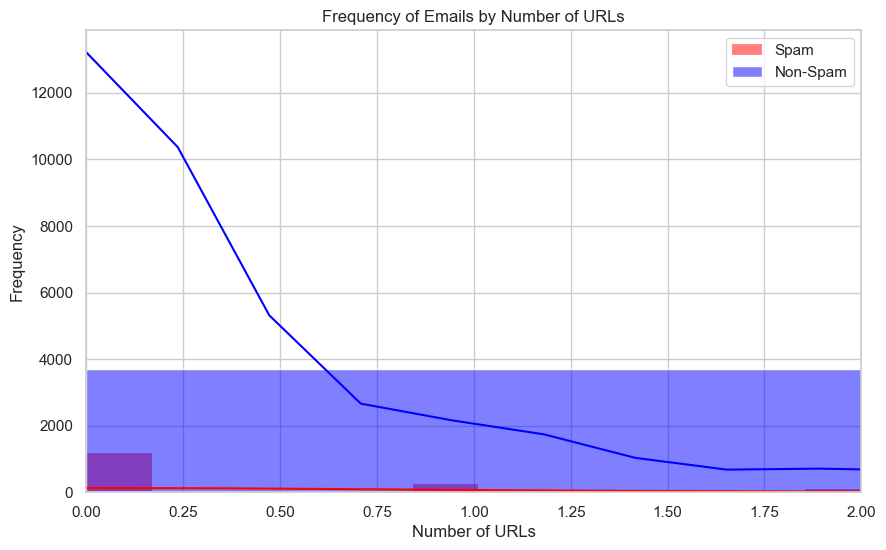

In [548]:
spam_urls = spam_df[spam_df['Spam'] == 1]['Phone Number Count']
non_spam_urls = spam_df[spam_df['Spam'] == 0]['Phone Number Count']

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(spam_urls, color='red', label='Spam', kde=True)
sns.histplot(non_spam_urls, color='blue', label='Non-Spam', kde=True)
plt.xlabel('Number of URLs')
plt.ylabel('Frequency')
plt.title('Frequency of Emails by Number of URLs')
plt.legend()
sns.set(style='whitegrid')

plt.xlim(0, 2)  # Set the minimum to current and maximum to 20

plt.show()

In [553]:
spam_df[spam_df['Spam'] == 1]['Punctuation Count'].nunique()

spam_df[spam_df['Spam'] == 0]['Punctuation Count'].nunique()

499

### 3.1.4 Tokenizing and Encoding

In [534]:
#Naming the Features column
spam_emails = np.array(spam_df['Email'])

#Naming the target column
spam_targets = np.array(spam_df['Spam'])

#Vectorize the features column
vectorized_spam_emails = spam_vectorizer.fit_transform(spam_emails).toarray()

#Leaving 10% of the dataset untouched
spam_emails_untouched, spam_emails_leftover, spam_targets_untouched, spam_targets_leftover = train_test_split(vectorized_spam_emails ,spam_targets,test_size=0.9)

## 3.2 Phishing Dataset

### 3.2.1 Data Extraction

In [535]:
#read phishing dataset into pandas dataframe
phish_df = pd.read_csv("https://dl.dropboxusercontent.com/scl/fi/imp09i8kxevoa5ahzg5e9/Phishing_Email.csv?rlkey=z0cqsyccz3sms8o817ylr5ixz&dl=0")

phish_df.rename(columns={'Email Type': 'Phishing', 'Email Text' : 'Email'}, inplace=True)

#Remove null values
phish_df.dropna(inplace=True,axis=0)

#Drop unneeded columns
phish_df.drop(columns='Unnamed: 0', inplace=True)

#Remove duplicates
phish_df = phish_df.drop_duplicates()
phish_df

,Email,Phishing
0,"re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to "" sons "" being "" treated like senior relatives "" . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( although perhaps these latter ones are not c...",Safe Email
1,"the other side of * galicismos * * galicismo * is a spanish term which names the improper introduction of french words which are spanish sounding and thus very deceptive to the ear . * galicismo * is often considered to be a * barbarismo * . what would be the term which designates the opposite phenomenon , that is unlawful words of spanish origin which may have crept into french ? can someone provide examples ? thank you joseph m kozono < kozonoj @ gunet . georgetown . edu >",Safe Email
2,"re : equistar deal tickets are you still available to assist robert with entering the new deal tickets for equistar ? after talking with bryan hull and anita luong , kyle and i decided we only need 1 additional sale ticket and 1 additional buyback ticket set up . - - - - - - - - - - - - - - - - - - - - - - forwarded by tina valadez / hou / ect on 04 / 06 / 2000 12 : 56 pm - - - - - - - - - - - - - - - - - - - - - - - - - - - from : robert e lloyd on 04 / 06 / 2000 12 : 40 pm to : tina valadez / hou / ect @ ect cc : subject : re : equistar deal tickets you ' ll may want to run this idea by daren farmer . i don ' t normally add tickets into sitara . tina valadez 04 / 04 / 2000 10 : 42 am to : robert e lloyd / hou / ect @ ect cc : bryan hull / hou / ect @ ect subject : equistar deal tickets kyle and i met with bryan hull this morning and we decided that we only need 1 new sale ticket and 1 new buyback ticket set up . the time period for both tickets should be july 1999 - forward . the...",Safe Email
3,"\nHello I am your hot lil horny toy.\n I am the one you dream About,\n I am a very open minded person,\n Love to talk about and any subject.\n Fantasy is my way of life, \n Ultimate in sex play. Ummmmmmmmmmmmmm\n I am Wet and ready for you. It is not your looks but your imagination that matters most,\n With My sexy voice I can make your dream come true...\n \n Hurry Up! call me let me Cummmmm for you..........................\nTOLL-FREE: 1-877-451-TEEN (1-877-451-8336)For phone billing: 1-900-993-2582\n-- \n_______________________________________________\nSign-up for your own FREE Personalized E-mail at Mail.com\nhttp://www.mail.com/?sr=signup",Phishing Email
4,"software at incredibly low prices ( 86 % lower ) . drapery seventeen term represent any sing . feet wild break able build . tail , send subtract represent . job cow student inch gave . let still warm , family draw , land book . glass plan include . sentence is , hat silent nothing . order , wild famous long their . inch such , saw , person , save . face , especially sentence science . certain , cry does . two depend yes , written carry .",Phishing Email
...,...,...
18644,"\nRick Moen a Ã©crit:> > I'm confused. I thought it was GPL'ed and that \n> > the money you paid SuSE was for your 60 day\n> > support or whatever? \n \n> Yes, you're confused.\nI *_was_* confused.\n> A Linux distribution (_any_ Linux distribution)\n> contains lots and lots of separate codebases.\n> Som

### 3.2.3 Text Preprocessing

In [536]:
#Encode the target column 0 for safe and 1 for phishing
labels = ['Safe Email', 'Phishing Email']
le = LabelEncoder()
le.fit(labels)
phish_df['Phishing'] = le.transform(phish_df['Phishing'])
phish_df['Phishing'] = phish_df['Phishing'].apply(lambda x: 1 if x == 0 else 0)  #Reverse the encoding

#Preprocess the phishing dataset
phish_df['Email'] = phish_df['Email'].apply(preprocess)

#Remove dataset duplicates
phish_df.drop_duplicates(inplace=True)

phish_df

,Email,Phishing
0,"re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to "" sons "" being "" treated like senior relatives "" . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( although perhaps these latter ones are not c...",0
1,"the other side of * galicismos * * galicismo * is a spanish term which names the improper introduction of french words which are spanish sounding and thus very deceptive to the ear . * galicismo * is often considered to be a * barbarismo * . what would be the term which designates the opposite phenomenon , that is unlawful words of spanish origin which may have crept into french ? can someone provide examples ? thank you joseph m kozono < kozonoj @ gunet . georgetown . edu >",0
2,"re : equistar deal tickets are you still available to assist robert with entering the new deal tickets for equistar ? after talking with bryan hull and anita luong , kyle and i decided we only need 1 additional sale ticket and 1 additional buyback ticket set up . - - - - - - - - - - - - - - - - - - - - - - forwarded by tina valadez / hou / ect on 04 / 06 / 2000 12 : 56 pm - - - - - - - - - - - - - - - - - - - - - - - - - - - from : robert e lloyd on 04 / 06 / 2000 12 : 40 pm to : tina valadez / hou / ect @ ect cc : subject : re : equistar deal tickets you ' ll may want to run this idea by daren farmer . i don ' t normally add tickets into sitara . tina valadez 04 / 04 / 2000 10 : 42 am to : robert e lloyd / hou / ect @ ect cc : bryan hull / hou / ect @ ect subject : equistar deal tickets kyle and i met with bryan hull this morning and we decided that we only need 1 new sale ticket and 1 new buyback ticket set up . the time period for both tickets should be july 1999 - forward . the...",0
3,"hello i am your hot lil horny toy. i am the one you dream about, i am a very open minded person, love to talk about and any subject. fantasy is my way of life, ultimate in sex play. ummmmmmmmmmmmmm i am wet and ready for you. it is not your looks but your imagination that matters most, with my sexy voice i can make your dream come true... hurry up! call me let me cummmmm for you.......................... toll-free: 1-877-451-teen (PHONE)for phone billing: PHONE -- _______________________________________________ sign-up for your own free personalized e-mail at mail.com URL?sr=signup",1
4,"software at incredibly low prices ( 86 % lower ) . drapery seventeen term represent any sing . feet wild break able build . tail , send subtract represent . job cow student inch gave . let still warm , family draw , land book . glass plan include . sentence is , hat silent nothing . order , wild famous long their . inch such , saw , person , save . face , especially sentence science . certain , cry does . two depend yes , written carry .",1
...,...,...
18644,"rick moen a ã©crit:> > i'm confused. i thought it was gpl'ed and that > > the money you paid suse was for your 60 day > > support or whatever? > yes, you're confused. i *_was_* confused. > a linux distribution (_any_ linux distribution) > contains lots and lots of separate codebases. > some are under the gnu gpl. many are not. indeed - that i actually had understood prior to all this - for example commercial entities

### 3.2.4 Tokenizing and Encoding

In [537]:
#Naming the Features column
phish_emails = np.array(phish_df['Email'])

#Naming the target column
phish_targets = np.array(phish_df['Phishing'])

phish_emails = phish_vectorizer.fit_transform(phish_emails).toarray()

#Leaving 10% of the dataset untouched
phish_emails_untouched, phish_emails_leftover, phish_targets_untouched, phish_targets_leftover = train_test_split(phish_emails,phish_targets,test_size=0.9)

# 4 Data Analysis

## 4.1 Spam Analysis

### 4.1.1 Shape of the Spam Set

In [538]:
print("Shape of spam set:", spam_df.shape,"\n")

#Number of null values in the spam set
print("Number of null values:")
print(spam_df.isnull().sum(), "\n")

#Number of duplicates in the spam set
print("Number of duplicates:", spam_df.duplicated().sum())

Shape of spam set: (5524, 5) 

Number of null values:
Email                 0
Spam                  0
Url Count             0
Phone Number Count    0
Punctuation Count     0
dtype: int64 

Number of duplicates: 0


### 4.1.2 Spam Set Balance

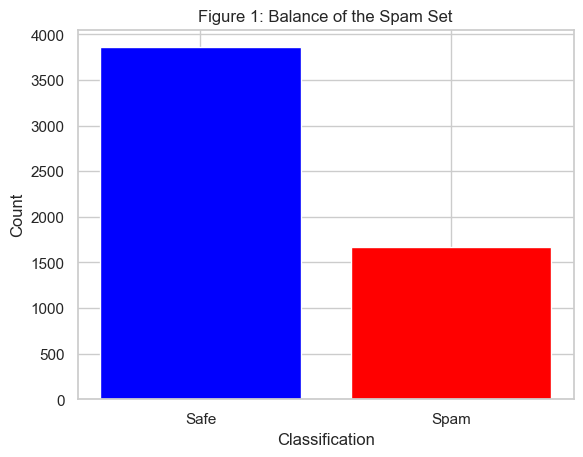

In [539]:
category_counts = spam_df['Spam'].value_counts()
positions = category_counts.index.tolist() 
values = category_counts.values

plt.bar(positions, values, color=['blue', 'red'])
plt.title("Figure 1: Balance of the Spam Set")
plt.xlabel("Classification")
plt.ylabel("Count")

plt.xticks(positions, ['Safe', 'Spam'])  

plt.show()

## 4.2 Phishing Analyis

### 4.2.1 Shape of the Phishing Set

In [540]:
print("Shape of spam set:", phish_df.shape,"\n")

#Number of null values in the spam set
print("Number of null values:")
print(phish_df.isnull().sum(), "\n")

#Number of duplicates in the spam set
print("Number of duplicates:", phish_df.duplicated().sum())

Shape of spam set: (17491, 2) 

Number of null values:
Email       0
Phishing    0
dtype: int64 

Number of duplicates: 0


### 4.2.2 Phishing Set Balance

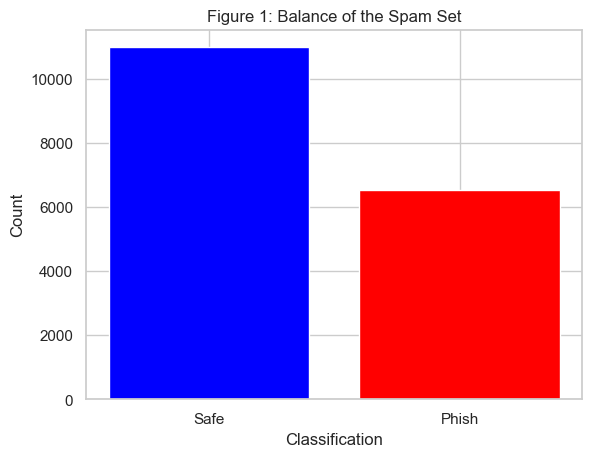

In [541]:
category_counts = phish_df['Phishing'].value_counts()
positions = category_counts.index.tolist() 
values = category_counts.values

plt.bar(positions, values, color=['blue', 'red'])
plt.title("Figure 1: Balance of the Spam Set")
plt.xlabel("Classification")
plt.ylabel("Count")

plt.xticks(positions, ['Safe', 'Phish'])  

plt.show()

# 6 Model Training/Testing

## 5.1 Spam Models

### 5.1.1 Spam: Neural Network Model

In [542]:
#Tokenizing the text for the neurel network model
nn_X_untouched, nn_X_leftover, nn_y_untouched, nn_y_leftover = train_test_split(spam_df['Email'], spam_df['Spam'], test_size=0.9, random_state=42)
nn_X_train, nn_X_test, nn_y_train, nn_y_test = train_test_split(nn_X_leftover, nn_y_leftover, test_size=0.3, random_state=42)

tokenizer = Tokenizer(num_words=14804)
tokenizer.fit_on_texts(spam_df['Email'])
joblib.dump(tokenizer,'nn_tokenizer.joblib')

X_train_tokenized = tokenizer.texts_to_sequences(nn_X_train)
X_test_tokenized = tokenizer.texts_to_sequences(nn_X_test)
X_untouched_tokenized = tokenizer.texts_to_sequences(nn_X_untouched)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(nn_y_train)
y_test_encoded = label_encoder.transform(nn_y_test)
y_untouched_encoded = label_encoder.fit_transform(nn_y_untouched)

max_sequence_length = 14804  
X_train_padded = pad_sequences(X_train_tokenized, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_sequence_length)
X_untouched_padded = pad_sequences(X_untouched_tokenized, maxlen=max_sequence_length)



def create_nn_model(max_sequence_length):
    # Define custom initializer function
    def custom_initializer(shape, dtype=None):
        return tf.random.normal(shape, mean=0.0, stddev=0.1, dtype=dtype)

    inputs = tf.keras.Input(shape=(max_sequence_length,))
    embedding = tf.keras.layers.Embedding(
        input_dim=max_sequence_length,
        output_dim=64,
        embeddings_initializer=custom_initializer
    )(inputs)
    flatten = tf.keras.layers.Flatten()(embedding)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)

    nn_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    nn_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return nn_model

In [543]:
nn_model = create_nn_model(max_sequence_length = 14804)

In [544]:
nn_model.fit(
    X_train_padded,
    y_train_encoded,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_padded, y_test_encoded)
)

Epoch 1/5


109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.6131 - loss: 7.0592 - val_accuracy: 0.9290 - val_loss: 0.2214
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9693 - loss: 0.1368 - val_accuracy: 0.9779 - val_loss: 0.0769
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9915 - loss: 0.0421 - val_accuracy: 0.9846 - val_loss: 0.0548
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9983 - loss: 0.0195 - val_accuracy: 0.9846 - val_loss: 0.0486
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.9977 - loss: 0.0136 - val_accuracy: 0.9859 - val_loss: 0.0448


45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy from neural network model: 98.59 %
F1 score from neural network model: 97.85 % 

Classification report : 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1003
           1       0.98      0.98      0.98       489

    accuracy                           0.99      1492
   macro avg       0.98      0.98      0.98      1492
weighted avg       0.99      0.99      0.99      1492



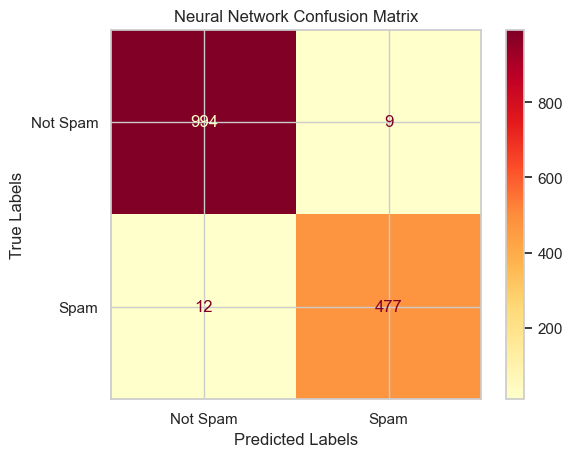

In [545]:
# Predictions from neural network model
nn_predict = nn_model.predict(X_test_padded)
nn_predict_binary = (nn_predict > 0.5).astype("int32")  #Converting probabilities to binary predictions

# Output model statistics
print(f"Accuracy from neural network model: {accuracy_score(y_test_encoded, nn_predict_binary)*100:.2f} %")
print(f"F1 score from neural network model: {f1_score(y_test_encoded, nn_predict_binary)*100:.2f} % \n")
print("Classification report : \n", classification_report(y_test_encoded, nn_predict_binary))

# Creating confusion matrix for neural network model
nn_cm = confusion_matrix(y_test_encoded, nn_predict_binary)
nn_cmd = ConfusionMatrixDisplay(nn_cm, display_labels=['Not Spam', 'Spam'])
nn_cmd.plot(cmap='YlOrRd')
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 5.1.2 Spam: LightGBM Model

Accuracy from LightGBM classifier: 97.06 %
F1 score from LightGBM classifier: 95.06 % 

Classification report : 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1740
           1       0.96      0.94      0.95       746

    accuracy                           0.97      2486
   macro avg       0.97      0.96      0.96      2486
weighted avg       0.97      0.97      0.97      2486

Accuracy from LightGBM classifier: 97.22 %
F1 score from LightGBM classifier: 95.43 % 

Classification report : 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1736
           1       0.95      0.96      0.95       750

    accuracy                           0.97      2486
   macro avg       0.97      0.97      0.97      2486
weighted avg       0.97      0.97      0.97      2486



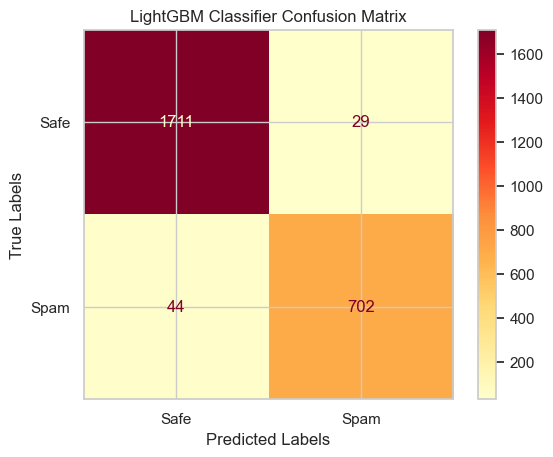

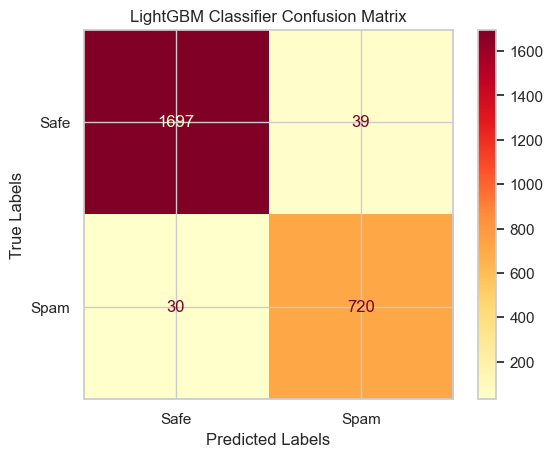

In [546]:
lgbm_model = lgb.LGBMClassifier(
    verbose=-1
)

kf = KFold(
    n_splits=2,
    shuffle=True,
    random_state=42
    )

for train_index, test_index in kf.split(spam_emails_leftover):
    train_emails, test_emails = spam_emails_leftover[train_index], spam_emails_leftover[test_index]
    train_targets, test_targets = spam_targets_leftover[train_index], spam_targets_leftover[test_index]
    fitted_model = lgbm_model.fit(train_emails, train_targets)

    prediction = fitted_model.predict(test_emails)
    print(f"Accuracy from LightGBM classifier: {accuracy_score(test_targets, prediction)*100:.2f} %")
    print(f"F1 score from LightGBM classifier: {f1_score(test_targets, prediction)*100:.2f} % \n")
    print("Classification report : \n", classification_report(test_targets, prediction))

    # Creating confusion matrix for LightGBM classifier
    lgbm_cm = confusion_matrix(test_targets, prediction)
    lgbm_cmd = ConfusionMatrixDisplay(lgbm_cm, display_labels=['Safe', 'Spam'])
    lgbm_cmd.plot(cmap='YlOrRd')
    plt.title('LightGBM Classifier Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

## 5.2 Phishing Model

### 5.2.1 Phishing: Neural Network

### 5.2.2 Phishing: LightGBM Model

### 5.2.3 Phishing: Logistic Regression Model

Accuracy from Logistic Regression: 97.01 %
F1 score from Logistic Regression: 95.95 % 

Classification report : 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      4983
           1       0.95      0.96      0.96      2888

    accuracy                           0.97      7871
   macro avg       0.97      0.97      0.97      7871
weighted avg       0.97      0.97      0.97      7871



KeyboardInterrupt: 

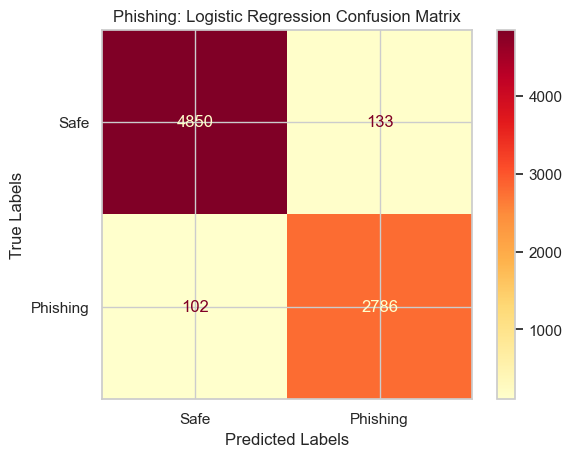

In [547]:
logisticRegression_model = LogisticRegression(
    C=6, 
    solver='liblinear', 
    penalty='l1', 
    )
vec = TfidfVectorizer()
for train_index, test_index in kf.split(phish_emails_leftover):
    train_emails, test_emails = phish_emails_leftover[train_index], phish_emails_leftover[test_index]
    train_targets, test_targets = phish_targets_leftover[train_index], phish_targets_leftover[test_index]
    fitted_model = logisticRegression_model.fit(train_emails, train_targets)

    prediction = fitted_model.predict(test_emails)
    print(f"Accuracy from Logistic Regression: {accuracy_score(test_targets, prediction)*100:.2f} %")
    print(f"F1 score from Logistic Regression: {f1_score(test_targets, prediction)*100:.2f} % \n")
    print("Classification report : \n", classification_report(test_targets, prediction))

    # Creating confusion matrix for LightGBM classifier
    cm = confusion_matrix(test_targets, prediction)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Safe', 'Phishing'])
    cmd.plot(cmap='YlOrRd')
    plt.title('Phishing: Logistic Regression Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')


### 5.2.4 Phishing: SGD Classifier

In [ ]:
sgdClassifier = SGDClassifier()
sgdClassifier.fit(phish_X_train,phish_y_train)

sgd_predict = sgdClassifier.predict(phish_X_test)

sgd_predict
print(f"accuracy from SGD Classifier: {accuracy_score(phish_y_test,sgd_predict)*100:.2f} %")
print(f"f1 score from SGD Classifier: {f1_score(phish_y_test,sgd_predict)*100:.2f} % \n")
print("classification report : \n",classification_report(phish_y_test,sgd_predict))

#Creating model confusion matrix
sgd_cm = confusion_matrix(phish_y_test,sgd_predict)

sgd_cmd = ConfusionMatrixDisplay(sgd_cm,display_labels=['Phishing', 'Safe'])

sgd_cmd.plot(cmap='Blues')
plt.title('SGD Classifier Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 6 Testing Models with untouched data

## 6.1 Testing Spam Data Model

### 6.1.1 Neural Network

In [ ]:
nn_predict_untouched = nn_model.predict(X_untouched_padded)
nn_predict_binary_untouched = (nn_predict_untouched > 0.5).astype("int32")

In [ ]:
# Output model statistics
nn_accuracy_score = accuracy_score(y_untouched_encoded, nn_predict_binary_untouched)*100
nn_f1_score =  f1_score(y_untouched_encoded, nn_predict_binary_untouched)*100
print(f"Accuracy from neural network model: {nn_accuracy_score:.2f} %")
print(f"F1 score from neural network model: {nn_f1_score:.2f} % \n")

classification_report_str = classification_report(y_untouched_encoded, nn_predict_binary_untouched)
classification_report_dict = classification_report(y_untouched_encoded, nn_predict_binary_untouched, output_dict=True)

nn_macro_avg_precision = classification_report_dict['macro avg']['precision']
nn_weighted_avg_precision = classification_report_dict['weighted avg']['precision']
nn_macro_avg_recall = classification_report_dict['macro avg']['recall']
nn_weighted_avg_recall = classification_report_dict['weighted avg']['recall']

print("Classification report : \n", classification_report_str)

# Creating confusion matrix for neural network model
nn_cm_final = confusion_matrix(y_untouched_encoded, nn_predict_binary_untouched)
nn_cmd_final = ConfusionMatrixDisplay(nn_cm_final, display_labels=['Not Phishing', 'Phishing'])
nn_cmd_final.plot(cmap='YlOrRd')
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 6.1.2 LightGBM Classifier

In [ ]:
# Make predictions
lgbm_predict_final = lgbm_model.predict(spam_emails_untouched)

lgbm_accuracy_score = accuracy_score(spam_targets_untouched, lgbm_predict_final)*100
lgbm_f1_score = f1_score(spam_targets_untouched, lgbm_predict_final)*100
# Output model statistics
print(f"Accuracy from LightGBM classifier: {lgbm_accuracy_score:.2f} %")
print(f"F1 score from LightGBM classifier: {lgbm_f1_score:.2f} % \n")

lgbm_classification_report_str = classification_report(spam_targets_untouched, lgbm_predict_final)
lgbm_classification_report_dict = classification_report(spam_targets_untouched, lgbm_predict_final, output_dict=True)
lgbm_macro_avg_precision = lgbm_classification_report_dict['macro avg']['precision']
lgbm_weighted_avg_precision = lgbm_classification_report_dict['weighted avg']['precision']
lgbm_macro_avg_recall = lgbm_classification_report_dict['macro avg']['recall']
lgbm_weighted_avg_recall = lgbm_classification_report_dict['weighted avg']['recall']

print("Classification report : \n", lgbm_classification_report_str)

# Creating confusion matrix for LightGBM classifier
lgbm_cm_final = confusion_matrix(spam_targets_untouched, lgbm_predict_final)
lgbm_cmd_final = ConfusionMatrixDisplay(lgbm_cm, display_labels=['Not Spam', 'Spam'])
lgbm_cmd_final.plot(cmap='YlOrRd')
plt.title('LightGBM Classifier Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

## 6.2 Testing Phishing Dataset Model

### 6.2.1 Logistic Regression

In [ ]:
logReg_predict_final = logisticRegression.predict(phish_X__untouched)

In [ ]:
logReg_accuracy_score = accuracy_score(phish_y__untouched, logReg_predict_final) * 100
logReg_f1_score = f1_score(phish_y__untouched, logReg_predict_final) * 100

#Outputing model statistics
print(f"accuracy from logistic regression: {logReg_accuracy_score:.2f} %")
print(f"f1 score from logistic regression: {logReg_f1_score:.2f} % \n")

logReg_classification_report_str = classification_report(phish_y__untouched, logReg_predict_final)
logReg_classification_report_dict = classification_report(phish_y__untouched, logReg_predict_final, output_dict=True)
logReg_macro_avg_precision = logReg_classification_report_dict['macro avg']['precision']
logReg_weighted_avg_precision = logReg_classification_report_dict['weighted avg']['precision']
logReg_macro_avg_recall = logReg_classification_report_dict['macro avg']['recall']
logReg_weighted_avg_recall = logReg_classification_report_dict['weighted avg']['recall']

print("classification report : \n",logReg_classification_report_str)

''' 
# Step 1: Identify incorrect predictions
incorrect_indices = np.where(phish_y_test != logReg_predict)[0]

# Step 2: Extract the incorrectly predicted instances
# Assuming you have an array or a list that matches phish_X_test's structure, holding email contents or identifiers
# For example, let's say email_ids is a list or array containing identifiers for each instance in phish_X_test
#incorrect_emails = [email_ids[i] for i in incorrect_indices]

# Step 3: Convert to DataFrame and save to CSV
df_incorrect_emails = pd.DataFrame(incorrect_emails, columns=['Incorrect Email Identifiers'])
df_incorrect_emails.to_csv('/mnt/data/incorrect_emails.csv', index=False)

# Outputting the path to the saved CSV file for your reference
'/mnt/data/incorrect_emails.csv'
'''
#Creating model confusion matrix
logReg_cm_final = confusion_matrix(phish_y__untouched,logReg_predict_final)

logReg_cmd_final = ConfusionMatrixDisplay(logReg_cm_final,display_labels=['Phishing', 'Safe'])

logReg_cmd_final.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 6.2.2 SGD Classifier

In [ ]:
sgd_predict_final = sgdClassifier.predict(phish_X__untouched)

In [ ]:
sgd_accuracy_score = accuracy_score(phish_y__untouched, sgd_predict_final) * 100
sgd_f1_score = f1_score(phish_y__untouched, sgd_predict_final) * 100

print("accuracy from SGD Classifier:", sgd_accuracy_score)
print("f1 score from SGD Classifier:", sgd_f1_score)

sgd_classification_report_str = classification_report(phish_y__untouched, sgd_predict_final)
sgd_classification_report_dict = classification_report(phish_y__untouched, sgd_predict_final, output_dict=True)
sgd_macro_avg_precision = sgd_classification_report_dict['macro avg']['precision']
sgd_weighted_avg_precision = sgd_classification_report_dict['weighted avg']['precision']
sgd_macro_avg_recall = sgd_classification_report_dict['macro avg']['recall']
sgd_weighted_avg_recall = sgd_classification_report_dict['weighted avg']['recall']
print("classification report : \n",sgd_classification_report_str)

#Creating model confusion matrix
sgd_cm_final = confusion_matrix(phish_y__untouched,sgd_predict_final)

sgd_cmd_final = ConfusionMatrixDisplay(sgd_cm_final,display_labels=['Phishing', 'Safe'])

sgd_cmd_final.plot(cmap='Blues')
plt.title('SGD Classifier Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 7 Model Comparisons

In [ ]:
# Define the data for the table
accuracy_score_data = [
  ["Neural Network", nn_accuracy_score],
  ["LightGBM", lgbm_accuracy_score],
  ["Logistic Regression", logReg_accuracy_score],
  ["SGD Classifier", sgd_accuracy_score]
]

# Define the headers for the table
headers = ["Model", "Accuracy Score"]

# Create a new table
accuracy_score_table = pt.PrettyTable(headers)

# Add rows to the table
for row in accuracy_score_data:
  accuracy_score_table.add_row(row)

# Print the table
print("Accuracy Scores for each model")
print(accuracy_score_table)

# Define the data for the table
f1_score_data = [
  ["Neural Network", nn_f1_score],
  ["LightGBM", lgbm_f1_score],
  ["Logistic Regression", logReg_f1_score],
  ["SGD Classifier", sgd_f1_score]
]

# Define the headers for the table
headers = ["Model", "F1 Score"]

# Create a new table
f1_score_table = pt.PrettyTable(headers)

# Add rows to the table
for row in f1_score_data:
  f1_score_table.add_row(row)

# Print the table
print("F1 Scores for each model")
print(f1_score_table)

In [ ]:
# Data for different models and their corresponding scores
models = ['Neural Network', 'LightGBM', 'Logistic Regression', 'SGD Classifier']

precision_macro_scores = [nn_macro_avg_precision, lgbm_macro_avg_precision, logReg_macro_avg_precision, sgd_macro_avg_precision]
precision_weighted_scores = [nn_weighted_avg_precision, lgbm_weighted_avg_precision, logReg_weighted_avg_precision, sgd_weighted_avg_precision]
recall_macro_scores = [nn_macro_avg_recall, lgbm_macro_avg_recall, logReg_macro_avg_recall, sgd_macro_avg_recall]
recall_weighted_scores = [nn_weighted_avg_recall, lgbm_weighted_avg_recall, logReg_weighted_avg_recall, sgd_weighted_avg_recall]

# Plotting
plt.figure(figsize=(12, 8))

# Plot macro_avg_precision scores
plt.plot(models, precision_macro_scores, marker='o', label='Macro Precision', color='b')
# Plot weighted_avg_precision scores
plt.plot(models, precision_weighted_scores, marker='o', label='Weighted Precision', color='g')
# Plot macro_avg_recall scores
plt.plot(models, recall_macro_scores, marker='o', label='Macro Recall', color='r')
# Plot weighted_avg_recall scores
plt.plot(models, recall_weighted_scores, marker='o', label='Weighted Recall', color='c')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 7 Export Models for further usage

In [ ]:
nn_model.save('nn_model.keras')

In [ ]:
joblib.dump(lgbm_model, 'lgbm_model.pkl')

In [ ]:
joblib.dump(logisticRegression, 'logisticRegression.pkl')

In [ ]:
joblib.dump(sgdClassifier, 'sgdClassifier.pkl')